In [1]:
import os

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation

import gym_env
from render_utils import render_maze, render_DR, render_V, make_plots, record_trials, get_map, record_trajectory

In [2]:
# def record_trajectory(agent, traj):
#     fig, ax = plt.subplots()

#     m = get_map(agent)
    
#     # Display maze
#     cmap = plt.cm.Greys_r
#     cmap.set_bad('black', 1.0)
#     ax.imshow(m, origin='upper', cmap=cmap)
#     # Display agent
#     agent_loc = patches.Circle((agent.start_loc[1],agent.start_loc[0]), radius=0.4, fill=True, color='blue')
#     ax.add_patch(agent_loc)
#     # Display Reward
#     reward = patches.Circle((agent.target_loc[1],agent.target_loc[0]), radius=0.4, fill=True, color='green')
#     ax.add_patch(reward)

#     # loop through trajectory and add arrows
#     for i in range(0,len(traj)-1):
#         diff = traj[i+1] - traj[i]
#         arrow = patches.Arrow(x=traj[i][1], y=traj[i][0], dx=0.3*diff[1], dy=0.5*diff[0], color="red")
#         # arrow = patches.Arrow((loc[1],loc[0]), fill=True, color='red')
#         ax.add_patch(arrow)

#     ax.set_title('Map')
#     ax.set_axis_off()

In [3]:
class LinearRL:
    def __init__(self, env_name, alpha, gamma, epsilon=0.4, num_steps=25000):
        self.env = gym.make(env_name)
        self.start_loc = self.env.unwrapped.start_loc
        self.target_loc = self.env.unwrapped.target_loc
        self.maze = self.env.unwrapped.maze
        self.size = self.maze.size
        self.height, self.width = self.maze.shape
        self.target_locs = [self.target_loc]
        self.mapping = self.create_transition_matrix_mapping()
        self.T = self.get_transition_matrix(size=self.size, mapping=self.mapping)

        # Get terminal states
        self.terminals = np.diag(self.T) == 1
        # Calculate P = T_{NT}
        self.P = self.T[~self.terminals][:,self.terminals]
        # self.P = self.T[:, self.terminals]
        # Calculate reward
        self.r = np.full(len(self.T), -1)     # our reward at each non-terminal state to be -1
        self.r[self.terminals] = 10           # reward at terminal state is 10
        self.expr = np.exp(self.r[self.terminals] / gamma)

        # Params
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_steps = num_steps

        # Model
        self.DR = np.eye(self.size)
        # self.DR = np.zeros((self.size, self.size))
        self.Z = np.zeros(self.size)
        self.V = np.zeros(self.size)
        self.one_hot = np.eye(self.size)
    
    def create_transition_matrix_mapping(self):
        """
        Creates a mapping from maze state indices to transition matrix indices
        """
        n = len(self.maze)  # Size of the maze (N)

        mapping = {}
        matrix_idx = 0

        for i in range(n):
            for j in range(n):
                mapping[(i,j)] = matrix_idx
                matrix_idx += 1

        return mapping
    
    def get_transition_matrix(self, size, mapping):
        T = np.zeros(shape=(size, size))
        # loop through the maze
        for row in range(self.maze.shape[0]):
            for col in range(self.maze.shape[1]):            
                # if we hit a barrier
                if self.maze[row,col] == '1':
                    continue

                idx_cur = mapping[row, col]

                # check if current state is terminal
                if self.maze[row,col] == 'G':
                    T[idx_cur, idx_cur] = 1
                    continue

                state = (row,col)
                successor_states = self.env.unwrapped.get_successor_states(state)
                for successor_state in successor_states:
                    idx_new = mapping[successor_state[0][0], successor_state[0][1]]
                    T[idx_cur, idx_new] = 1/len(successor_states)
        
        return T
    
    def update_V(self):
        self.Z[~self.terminals] = self.DR[~self.terminals][:,~self.terminals] @ self.P @ self.expr
        self.Z[self.terminals] = np.exp(self.r[self.terminals] / self.gamma)
        self.V = np.round(np.log(self.Z), 2)
    
    def importance_sampling(self, state, s_new_idx):
        successor_states = self.env.unwrapped.get_successor_states(state)
        p = 1/len(successor_states)
        w = (p * self.Z[s_new_idx]) / sum(p * self.Z[self.mapping[(s[0][0],s[0][1])]] for s in successor_states)
        
        return w
    
    def select_action(self, state, policy="e-greedy", epsilon=0.0, target_loc=None):
        if policy == "softmax":
            return
        elif policy == "e-greedy":
            if np.random.uniform(low=0,high=1) < epsilon:
                return self.env.unwrapped.random_action()
            else:
                action_values = np.full(self.env.action_space.n, -np.inf)
                for action in self.env.unwrapped.get_available_actions(state):
                    direction = self.env.unwrapped._action_to_direction[action]
                    new_state = state + direction
                    if self.maze[new_state[0], new_state[1]] == "1":
                        continue
                    action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

                return np.argmax(action_values)
        elif policy == "test":
            action_values = np.full(self.env.action_space.n, -np.inf)
            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction

                # Need this to make it work for now
                if np.array_equal(new_state, target_loc):
                    return action

                if self.maze[new_state[0], new_state[1]] == "1":
                    continue
                action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

            return np.argmax(action_values)
    
    def learn(self):
        """
        Agent randomly explores the maze and and updates its DR as it goes
        """
        self.env.reset()

        # Iterate through number of steps
        for i in range(self.num_steps):
            # Current state
            state = self.env.unwrapped.agent_loc
            state_idx = self.mapping[(state[0], state[1])]

            # Choose action (random for now)
            action = self.env.unwrapped.random_action()
            # action = self.select_action(state, epsilon=self.epsilon)

            # Take action
            obs, _, done, _, _ = self.env.step(action)

            if done:
                self.env.reset()
                continue

            # Unpack observation to get new state
            next_state = obs["agent"]
            next_state_idx = self.mapping[(next_state[0], next_state[1])]

            # Update Default Representation
            # w = self.importance_sampling(state, next_state_idx)
            # w = 1 if np.isnan(w) or w == 0 else w
            w = 1
            TDE =  self.one_hot[state_idx][~self.terminals] + self.gamma * self.DR[next_state_idx][~self.terminals]
            # TDE =  self.one_hot[state_idx] + self.gamma * self.DR[next_state_idx]

            self.DR[state_idx][~self.terminals] = (1 - self.alpha) * self.DR[state_idx][~self.terminals] + self.alpha * TDE * w
            # self.DR[state_idx] = (1 - self.alpha) * self.DR[state_idx] + self.alpha * TDE * w


            # Update Z-Values
            self.Z[state_idx] = self.DR[state_idx][~self.terminals] @ self.P @ self.expr
            # self.Z[state_idx] = self.DR[state_idx] @ self.P @ self.expr

            # Update state
            state = next_state
        
        self.Z[self.terminals] = np.exp(self.r[self.terminals] / self.gamma)
        self.V = np.round(np.log(self.Z), 2)

In [4]:
def test_agent(agent, state=None):
    traj = []

    agent.env.reset()
    if state is None:
        state = agent.start_loc

    # set the start and agent location
    agent.env.unwrapped.start_loc, agent.env.unwrapped.agent_loc = state, state
    print(f"Starting in state: {state}")
    steps = 0
    done = False
    while not done:
        action = agent.select_action(state, policy="test", target_loc=agent.target_loc)
        obs, _, done, _, _ = agent.env.step(action)
        next_state = obs["agent"]
        traj.append(next_state)
        print(f"Took action: {action} and arrived in state: {next_state}")

        steps += 1
        state = next_state
    print(f"Took {steps} steps")

    return traj

In [5]:
agent = LinearRL(env_name="tolman-9x9-nb", alpha=0.01, gamma=1.0, num_steps=500000)

In [6]:
# Run learning on non-blocked detour environment
agent.learn()

/Users/abizzle/anaconda3/envs/gym/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_77915/3774389332.py:166: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)


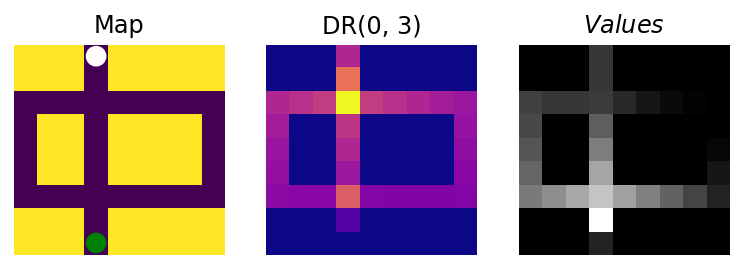

In [7]:
make_plots(agent)

In [8]:
print(f"Start location: {agent.start_loc}, Target location: {agent.target_loc}")
traj_not_blocked = test_agent(agent)

Start location: [0 3], Target location: [8 3]
Starting in state: [0 3]
Took action: 0 and arrived in state: [1 3]
Took action: 0 and arrived in state: [2 3]
Took action: 0 and arrived in state: [3 3]
Took action: 0 and arrived in state: [4 3]
Took action: 0 and arrived in state: [5 3]
Took action: 0 and arrived in state: [6 3]
Took action: 0 and arrived in state: [7 3]
Took action: 0 and arrived in state: [8 3]
Took 8 steps


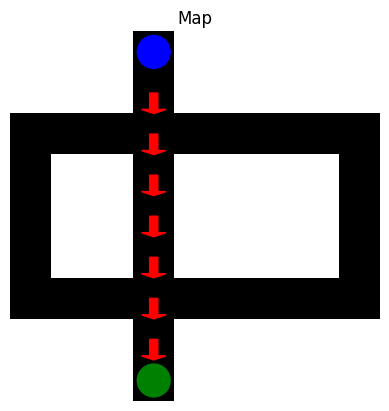

In [9]:
record_trajectory(agent, traj_not_blocked)

In [10]:
# L0 = np.diag(np.exp(-agent.r)/agent.gamma) - agent.T
# D0 = np.linalg.inv(L0)

# print(np.mean(np.square(agent.DR - D0)))

## Detour

In [11]:
# Get new maze and initialize a new agent
env_blocked = gym.make("tolman-9x9-b")
maze_blocked = env_blocked.unwrapped.maze
new_agent = LinearRL(env_name="tolman-9x9-b", alpha=0.1, gamma=0.8)

In [12]:
maze_blocked

array([['1', '1', '1', 'S', '1', '1', '1', '1', '1'],
       ['1', '1', '1', '0', '1', '1', '1', '1', '1'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['0', '1', '1', '0', '1', '1', '1', '1', '0'],
       ['0', '1', '1', '1', '1', '1', '1', '1', '0'],
       ['0', '1', '1', '0', '1', '1', '1', '1', '0'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['1', '1', '1', '0', '1', '1', '1', '1', '1'],
       ['1', '1', '1', 'G', '1', '1', '1', '1', '1']], dtype='<U21')

In [13]:
loc = (4,3)
idx = agent.mapping[loc]

In [14]:
D0 = agent.DR
L0 = np.diag(np.exp(-agent.r)) - agent.T
L = np.diag(np.exp(-agent.r)) - new_agent.T

In [15]:
changes = []

d = L[idx, :] - L0[idx, :]
m0 = D0[:,idx]

# Convert d to a row vector of size (1, m)
d = d.reshape(1, -1)

# Convert m0 to a column vector of size (m, 1)
m0 = m0.reshape(-1, 1)

print(f"d shape: {d.shape}, m0 shape: {m0.shape}")
print(f"numerator shape: {(np.dot(m0,d)).shape}")
print(f"denominator shape: {(np.dot(d, m0)).shape}")
alpha = (np.dot(m0,d)) / (1 + (np.dot(d,m0)))
print(f"alpha shape: {alpha.shape}")
change = np.dot(alpha,D0)
changes.append(change)

D = np.copy(D0)
for change in changes:
    D -= change

d shape: (1, 81), m0 shape: (81, 1)
numerator shape: (81, 81)
denominator shape: (1, 1)
alpha shape: (81, 81)


In [16]:
new_agent.DR = D
new_agent.update_V()

/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_77915/3774389332.py:79: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)
/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_77915/3774389332.py:79: RuntimeWarning: invalid value encountered in log
  self.V = np.round(np.log(self.Z), 2)


In [17]:
new_agent.V

array([ -inf,  -inf,  -inf,  9.69,  -inf,  -inf,  -inf,  -inf,  -inf,
        -inf,  -inf,  -inf,  9.74,  -inf,  -inf,  -inf,  -inf,  -inf,
       10.9 , 10.61, 10.28,  9.88, 10.04, 10.24, 10.41, 10.59, 10.75,
       11.14,  -inf,  -inf,  8.85,  -inf,  -inf,  -inf,  -inf, 10.95,
       11.31,  -inf,  -inf,   nan,  -inf,  -inf,  -inf,  -inf, 11.1 ,
       11.48,  -inf,  -inf, 11.38,  -inf,  -inf,  -inf,  -inf, 11.27,
       11.63, 11.77, 11.9 , 12.01, 11.91, 11.8 , 11.68, 11.54, 11.39,
        -inf,  -inf,  -inf, 12.61,  -inf,  -inf,  -inf,  -inf,  -inf,
        -inf,  -inf,  -inf, 12.5 ,  -inf,  -inf,  -inf,  -inf,  -inf])

In [18]:
new_agent.maze

array([['1', '1', '1', 'S', '1', '1', '1', '1', '1'],
       ['1', '1', '1', '0', '1', '1', '1', '1', '1'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['0', '1', '1', '0', '1', '1', '1', '1', '0'],
       ['0', '1', '1', '1', '1', '1', '1', '1', '0'],
       ['0', '1', '1', '0', '1', '1', '1', '1', '0'],
       ['0', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['1', '1', '1', '0', '1', '1', '1', '1', '1'],
       ['1', '1', '1', 'G', '1', '1', '1', '1', '1']], dtype='<U21')

In [19]:
print("Testing new agent with blocked environment")
print(f"Start location: {new_agent.start_loc}, Target location: {new_agent.target_loc}")
traj_blocked = test_agent(new_agent)

Testing new agent with blocked environment
Start location: [0 3], Target location: [8 3]
Starting in state: [0 3]
Took action: 0 and arrived in state: [1 3]
Took action: 0 and arrived in state: [2 3]
Took action: 3 and arrived in state: [2 2]
Took action: 3 and arrived in state: [2 1]
Took action: 3 and arrived in state: [2 0]
Took action: 0 and arrived in state: [3 0]
Took action: 0 and arrived in state: [4 0]
Took action: 0 and arrived in state: [5 0]
Took action: 0 and arrived in state: [6 0]
Took action: 1 and arrived in state: [6 1]
Took action: 1 and arrived in state: [6 2]
Took action: 1 and arrived in state: [6 3]
Took action: 0 and arrived in state: [7 3]
Took action: 0 and arrived in state: [8 3]
Took 14 steps


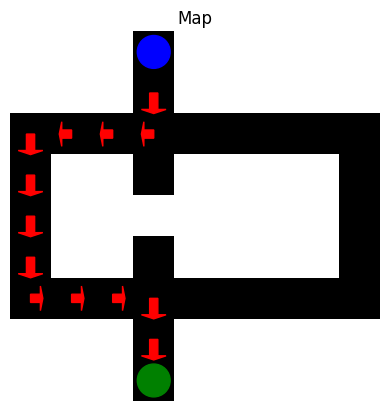

In [20]:
record_trajectory(new_agent, traj_blocked)